Step  1 → x=tensor([[-3.9449]], dtype=torch.float64),  y=tensor([[-4.2969]], dtype=torch.float64)


C:\Users\fqh\AppData\Local\anaconda3\envs\basenv\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(


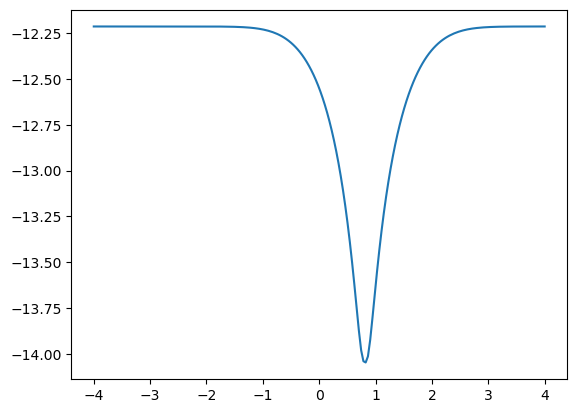

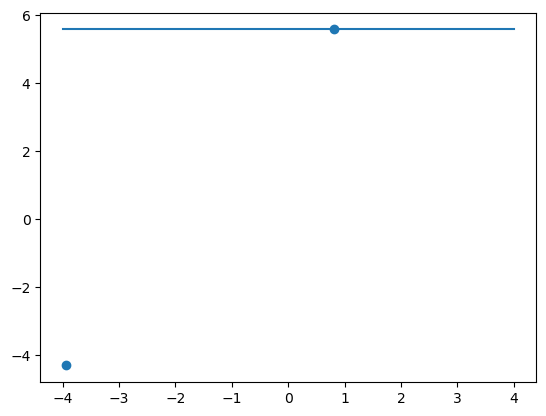

Step  2 → x=tensor([[1.4971]], dtype=torch.float64),  y=tensor([[18.4251]], dtype=torch.float64)


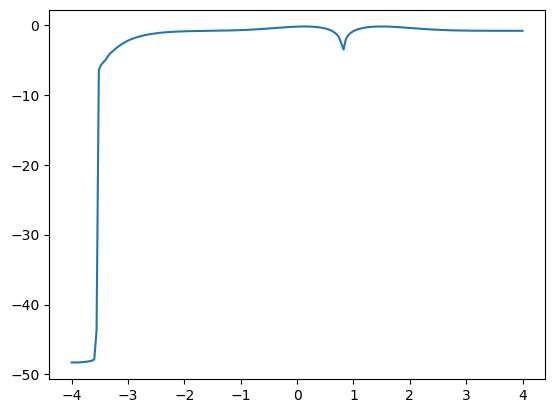

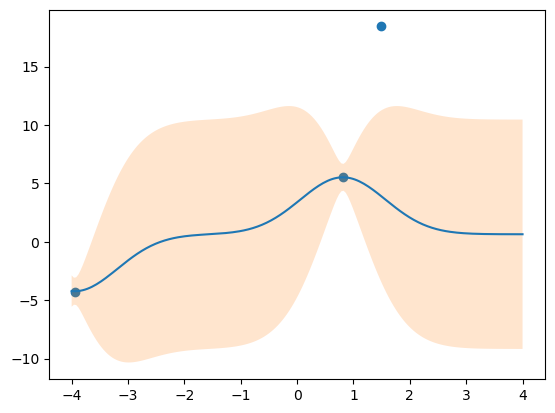

Step  3 → x=tensor([[1.5219]], dtype=torch.float64),  y=tensor([[20.4809]], dtype=torch.float64)


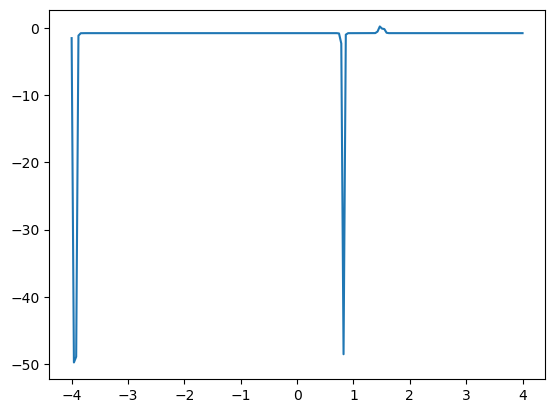

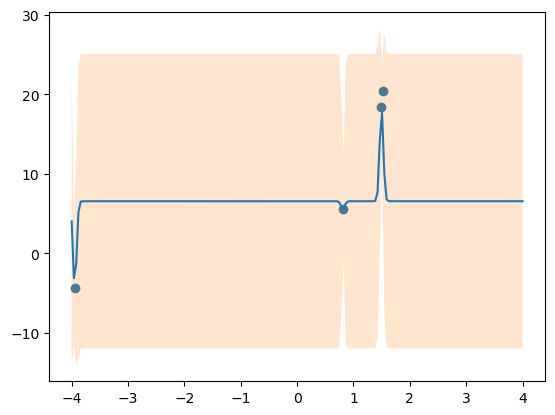

Step  4 → x=tensor([[1.6276]], dtype=torch.float64),  y=tensor([[20.0463]], dtype=torch.float64)


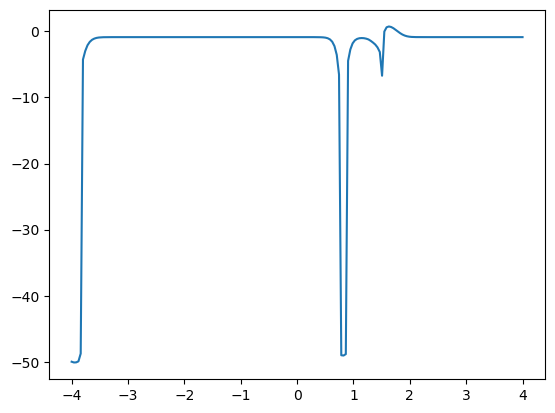

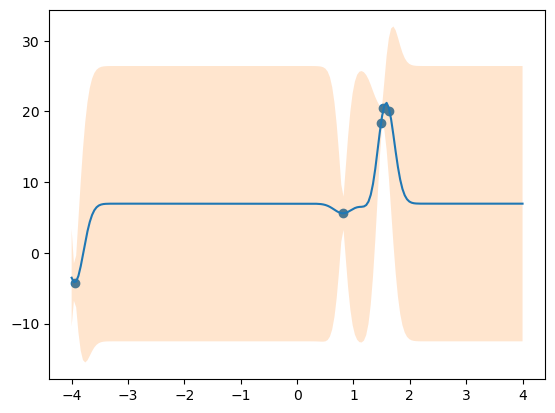

Step  5 → x=tensor([[1.9835]], dtype=torch.float64),  y=tensor([[28.9730]], dtype=torch.float64)


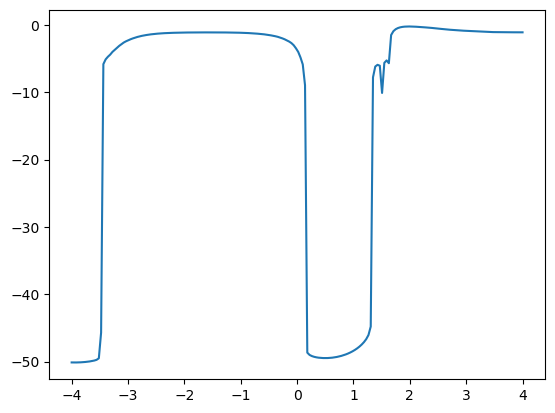

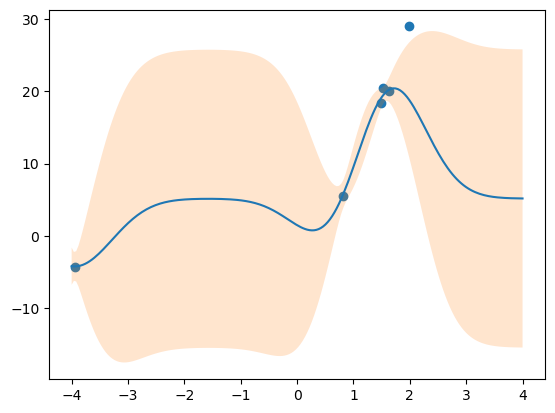

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from active_learning import step_GP, append_data, predict_posterior

# ground‐truth test function (scalar → scalar, 1D input)
def f(x: torch.Tensor, noise_level=5, noise=True):
    # x: (n,1) → returns (n,1)
    y = x.pow(4) - 14*x.pow(2) + 5*x
    if noise:
        return -y + torch.normal(0.0, noise_level, size=x.shape)
    else:
        return -y

NUM_INIT = 1
NOISE_LVL = 1
MAXIMIZE = True
ACQ = 'QNEI'
BATCH = 1

X = torch.rand(NUM_INIT, 1, dtype=torch.float64)
Y = f(X, noise_level=NOISE_LVL)

# save initial .npz (empty means/vars)
torch.save({'X':X, 'Y':Y,'mean':torch.empty_like(X),'var':torch.empty_like(Y), 'acq':torch.empty_like(Y)},"step_0.pt")

bounds = torch.tensor([[-4], [4]], dtype=torch.float64)  # shape (2,1)
X_test = torch.linspace(-4, 4, 200, dtype=torch.float64).unsqueeze(-1)  # (200,1)

N_STEPS = 5
for i in range(1, N_STEPS+1):
    # 4.1 Propose next point (batch=1), here we MINIMIZE the function:
    x_next, mean, var, acq = step_GP(
        X, Y, X_test, bounds,
        acq_func=ACQ,
        batch=BATCH,
        maximize=MAXIMIZE,
        num_restarts=10,
        raw_samples=100,
    )

    # 4.2 Run real experiment:
    y_next = f(x_next, noise_level=NOISE_LVL)

    # 4.3 Append & save
    X, Y = append_data(
        X, Y,
        X_new=x_next,
        Y_new=y_next,
        mean=mean,
        var=var,
        acq=acq,
        path=f"step_{i}.pt"
    )

    print(f"Step {i:2d} → x={x_next},  y={y_next}")

    plt.plot(X_test,acq);plt.show()

    mean_np = mean.squeeze(-1).numpy()
    std_np  = np.sqrt(var.squeeze(-1).numpy())

    plt.plot(X_test.squeeze().numpy(), mean_np)
    plt.scatter(X,Y)
    plt.fill_between(X_test.squeeze().numpy(),
                 mean_np - 2*std_np,
                 mean_np + 2*std_np,
                 alpha=0.2)
    plt.show()

In [2]:
# ◾ Report the optimum
Y_flat = Y.squeeze(-1)
if MAXIMIZE:
    best_idx = Y_flat.argmax()
else:
    best_idx = Y_flat.argmin()

X_best = X[best_idx]
Y_best = Y_flat[best_idx]

print("Optimal found:")
print(f"   X* = {X_best.numpy()}")
print(f"   Y* = {Y_best.item():.4f}")

Optimal found:
   X* = [1.98347303]
   Y* = 28.9730


In [3]:
X_test[f(X_test,noise=False).argmax()], f(X_test,noise=False).max()

(tensor([-2.7136], dtype=torch.float64), tensor(62.4357, dtype=torch.float64))

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from active_learning import step_GP, append_data, predict_posterior

# 2D ground-truth function
def f2(x: torch.Tensor, noise_level: float = 1.0, noise: bool = True) -> torch.Tensor:
    """
    x: Tensor of shape (N,2)
    returns: Tensor of shape (N,1)
    """
    x1, x2 = x[:, 0], x[:, 1]                           # each (N,)
    y1     = x1.pow(4) - 14*x1.pow(2) + 5*x1             # (N,)
    y2     = x2.pow(4) - 14*x2.pow(2) + 5*x2             # (N,)
    y      = -(y1 + y2 + 3*(x1*x2))                      # (N,)
    if noise:
        y = y + torch.normal(0.0, noise_level, size=y.shape, dtype=y.dtype, device=y.device)
    return y.unsqueeze(-1) 

# Parameters
NUM_INIT = 1
NOISE_LVL = 1
MAXIMIZE = True
ACQ = 'unc'
BATCH = 1
N_STEPS = 10

# Initial data
X = torch.rand(NUM_INIT, 2, dtype=torch.float64) * 8 - 4  # in [-4,4]^2
Y = f2(X, noise_level=NOISE_LVL)

# Domain and test grid
bounds = torch.tensor([[-4.0, -4.0], [4.0, 4.0]], dtype=torch.float64)
grid_lin = torch.linspace(-4, 4, 40, dtype=torch.float64)    # 40 points
X0, X1  = torch.meshgrid(grid_lin, grid_lin, indexing="ij") # each (40,40)
X_test  = torch.stack([X0.ravel(), X1.ravel()], dim=-1)      # (1600, 2)

# save initial .npz (empty means/vars)
torch.save({'X':X, 'Y':Y,'mean':torch.empty_like(X),'var':torch.empty_like(Y), 'acq':torch.empty_like(Y)},"step_0.pt")

for i in range(1, N_STEPS+1):
    # 4.1 Propose next point (batch=1), here we MINIMIZE the function:
    x_next, mean, var, acq = step_GP(
        X, Y, X_test, bounds,
        acq_func=ACQ,
        batch=BATCH,
        maximize=MAXIMIZE,
        num_restarts=100,
        raw_samples=100,
    )

    # 4.2 Run real experiment:
    y_next = f2(x_next, noise_level=NOISE_LVL)

    # 4.3 Append & save
    X, Y = append_data(
        X, Y,
        X_new=x_next,
        Y_new=y_next,
        mean=mean,
        var=var,
        acq=acq,
        path=f"step_{i}.pt"
    )

    print(f"Step {i:2d} → x={x_next},  y={y_next}")

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    
    # Posterior mean
    pcm = ax[0].pcolormesh(X0, X1,
                           mean.numpy().reshape(40,40),
                           shading="auto")
    ax[0].scatter(X[:,0], X[:,1], c="w", edgecolor="k")
    ax[0].set_title("GP Posterior Mean")
    fig.colorbar(pcm, ax=ax[0])
    
    # Acquisition
    pcm2 = ax[1].pcolormesh(X0, X1,
                            acq.exp().numpy().reshape(40,40),
                            shading="auto")
    ax[1].scatter(X[:,0], X[:,1], c="w", edgecolor="k")
    ax[1].set_title("Acquisition Surface")
    fig.colorbar(pcm2, ax=ax[1])
    
    plt.tight_layout()
    plt.show()



C:\Users\fqh\AppData\Local\anaconda3\envs\basenv\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(


In [11]:
# ◾ Report the optimum
Y_flat = Y.squeeze(-1)
if MAXIMIZE:
    best_idx = Y_flat.argmax()
else:
    best_idx = Y_flat.argmin()

X_best = X[best_idx]
Y_best = Y_flat[best_idx]

print("Optimal found:")
print(f"   X* = {X_best.numpy()}")
print(f"   Y* = {Y_best.item():.4f}")

X_test[f2(X_test,noise=False).argmax()], f2(X_test,noise=False).max()

Optimal found:
   X* = [ 2.671022  -2.8336215]
   Y* = 121.7098


(tensor([-2.7692,  2.7692], dtype=torch.float64),
 tensor(120.1118, dtype=torch.float64))

In [6]:
f2(x_next).shape

torch.Size([1, 1])

In [7]:
y_next

tensor([[99.7842]], dtype=torch.float64)